In [1]:
from pyspark.sql import SparkSession
import os
from plotnine import *
import pandas as pd
import numpy as np

import pyspark.sql.functions as F

In [ ]:
traces_location = "<directory_with_parquet_traces>"
list_of_workloads = list(map(lambda x: os.path.join(traces_location, x), os.listdir(traces_location)))
list_of_workloads

In [3]:
name_to_source_map = {
    "askalon-new": "Askalon New",
    "askalon": "Askalon Old",
    "icpe": "SPEC",
    "lanl": "LANL",
    "pegasus": "Pegasus",
    "workflowhub": "WorkflowHub",
    "two": "2Sigma",
    "google": "Google",
    "chronos": "Shell",
    "alibaba": "Alibaba",
}

# If a folder name (in lower case) starts with one of these strings, it has critical path info computed.
has_cp_info = [
    "askalon",
    "icpe",
    "pegasus",
    "workflowhub",
    "chronos",
    "alibaba",
]

In [4]:
spark = (SparkSession.builder
         .master("local[4]")
         .appName("Longitudinal Analysis")
         .config("spark.executor.memory", "8G")
         .config("spark.driver.memory", "2G")
         .getOrCreate())

In [5]:
def folder_name_to_source(folder_name):
    for name, source in name_to_source_map.items():
        if str(folder_name).startswith(name): return source
    raise NotImplementedError("Unknown folder!")

def do_workflows_exist(workload_location):
    return "workflows" in os.listdir(workload_location)

def read_trace(workload_location):
    return spark.read.parquet(os.path.join(workload_location, "workflows", "schema-1.0"))

def get_cp_task_count_column(df):
        return df.select("critical_path_task_count").filter(F.col("critical_path_task_count") >= 0).withColumnRenamed("critical_path_task_count", "cp_task_count")

def normalize_df(df):
    df.sort_values(df.columns[0], inplace=True)
    df["pdf"] = df["cp_task_count"] / df["cp_task_count"].sum()
    df["cdf"] = df["pdf"].cumsum()

In [ ]:
list_of_dfs = []
for workload in list_of_workloads:
    folder_name = str(os.path.basename(os.path.normpath(workload))).lower()
    
    if not any(folder_name.startswith(x) for x in has_cp_info):
        continue
        
    if not do_workflows_exist(workload):
        continue
    
    trace = read_trace(workload)
    pdf = get_cp_task_count_column(trace).toPandas()
    source = folder_name_to_source(folder_name)
    pdf["source"] = source
    
    normalize_df(pdf)
    list_of_dfs.append(pdf)

workflow_task_count_df = pd.concat(list_of_dfs, ignore_index = True)

def normalize_group(gp):
    gp = gp.groupby("cp_task_count").sum().reset_index()[["cp_task_count"]]
    normalize_df(gp)
    return gp

workflow_task_count_df = workflow_task_count_df.groupby("source").apply(normalize_group).reset_index()

In [7]:
def formatOneLabel(x):
    if x == 0:
        return "0"
    else:
        exponentNum = str(np.int32(np.floor(np.log10(x))))
        return "$10^{"+ exponentNum +"}$"


def formatYaxisLabels(xl):
    return list(map(formatOneLabel, xl))

/var/scratch/lvs215/miniconda3/envs/wtastats/lib/python3.7/site-packages/plotnine/ggplot.py:706: UserWarning: Saving 6 x 3 in image.
  from_inches(height, units), units))
/var/scratch/lvs215/miniconda3/envs/wtastats/lib/python3.7/site-packages/plotnine/ggplot.py:707: UserWarning: Filename: ./plots/crit_path_task_count_source_stratified.pdf
  warn('Filename: {}'.format(filename))


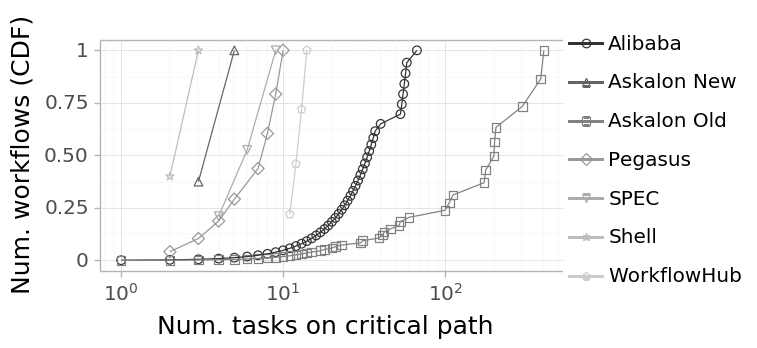

<ggplot: (2932166462426)>

In [10]:
plt = ggplot(workflow_task_count_df) +\
    theme_light(base_size=18) +\
    theme(legend_title=element_text(size=0, alpha=0),
                       legend_box_spacing=0.1,
                       legend_box_margin=0,
                       legend_margin=0,
         legend_position=(1.05, 0.5),
          legend_key=element_blank()) + \
    geom_point(aes(x="cp_task_count", y="cdf", color="source", shape="source"), stat=stat_identity, size=3, fill="none") +\
    geom_line(aes(x="cp_task_count", y="cdf", color="source", group="source"), stat=stat_identity) +\
    scale_color_grey() +\
    xlab("Num. tasks on critical path") +\
    ylab("Num. workflows (CDF)") +\
    scale_x_log10(labels=formatYaxisLabels)

os.makedirs("./plots", exist_ok=True)
ggsave(filename="./plots/crit_path_task_count_source_stratified.pdf",
       plot=plt,
       device='pdf',
       dpi=600,
       height=3,
       width=6)
plt